In [1]:
import pandas as pd
import os
import json
from sklearn.decomposition import PCA
from preprocessing import get_cliff_groups_test
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import sklearn
import matplotlib.gridspec as gridspec
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon

# Import Data

In [2]:
# choose from: 'CHEMBL234_Ki', 'CHEMBL214_Ki'
dataset = 'CHEMBL234_Ki'

In [3]:
df_test = pd.read_csv("../data/" + dataset + "/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/" + dataset + "/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test = df_test.dropna(subset=['cliff_group'])
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

In [4]:
results_test_rf = pd.read_csv("../results/" + dataset + "/Results_Test_RF.csv")
results_test_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Test_MLP_BCE.csv")
results_test_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Test_MLP_Cosine.csv")

results_test = [results_test_rf, results_test_mlp_bce, results_test_mlp_cosine]

In [5]:
results_cliff_groups_rf = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_RF.csv")
results_cliff_groups_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_MLP_BCE.csv")
results_cliff_groups_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_MLP_Cosine.csv")

In [6]:
losses_per_datapoint_test_total = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_RF.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_Cosine.csv")]
losses_per_datapoint_test_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_RF.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_Cosine.csv")]
losses_per_datapoint_test_non_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_RF.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_Cosine.csv")]

In [7]:
results_clusters = []

results_clusters_rf = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_RF.csv")
results_clusters_cliffs_rf = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_RF.csv")
results_clusters_non_cliffs_rf = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_RF.csv")
results_clusters.append([results_clusters_rf, results_clusters_non_cliffs_rf, results_clusters_cliffs_rf])

results_clusters_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_BCE.csv")
results_clusters_cliffs_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_BCE.csv")
results_clusters_non_cliffs_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_BCE.csv")
results_clusters.append([results_clusters_mlp_bce, results_clusters_non_cliffs_mlp_bce, results_clusters_cliffs_mlp_bce])

results_clusters_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_Cosine.csv")
results_clusters_cliffs_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_Cosine.csv")
results_clusters_non_cliffs_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_Cosine.csv")
results_clusters.append([results_clusters_mlp_cosine, results_clusters_non_cliffs_mlp_cosine, results_clusters_cliffs_mlp_cosine])

In [8]:
network_titles = ["RF", "MLP BCE", "MLP Triplet"]
results_networks = [results_cliff_groups_rf, results_cliff_groups_mlp_bce, results_cliff_groups_mlp_cosine]

In [9]:
data_groups = dict()

data_groups['Percentage_active'] = []
data_groups['Size_of_group'] = []

for group_id, group_data in df_test.groupby('cliff_group'):
    data_groups['Percentage_active'].append(sum(group_data['active']) / len(group_data))
    data_groups['Size_of_group'].append(len(group_data))

data_groups = pd.DataFrame(data_groups)

# Visualizations

In [10]:
col_dark_blue = '#0d0887'
col_medium_blue = '#6964b4'
col_violet = '#6a00a8'
col_pink = '#b12a90'
col_salmon = '#e16462'
col_orange = '#fca636'
col_yellow = '#d8e006'

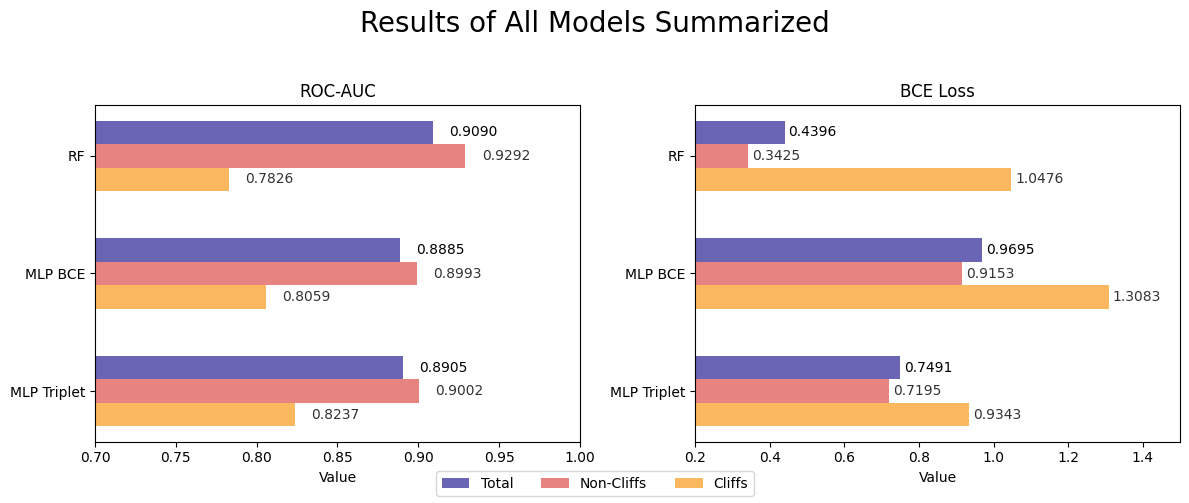

In [11]:
num_categories = len(network_titles)
y = np.arange(num_categories)

values_roc_auc_total = [results_test[0]['ROC-AUC_mean'][0], results_test[1]['ROC-AUC_mean'][0], results_test[2]['ROC-AUC_mean'][0]]
values_roc_auc_non_cliffs = [results_test[0]['ROC-AUC_mean'][1], results_test[1]['ROC-AUC_mean'][1], results_test[2]['ROC-AUC_mean'][1]]
values_roc_auc_cliffs = [results_test[0]['ROC-AUC_mean'][2], results_test[1]['ROC-AUC_mean'][2], results_test[2]['ROC-AUC_mean'][2]]

values_bce_total = [results_test[0]['Loss_mean'][0], results_test[1]['Loss_mean'][0], results_test[2]['Loss_mean'][0]]
values_bce_non_cliffs = [results_test[0]['Loss_mean'][1], results_test[1]['Loss_mean'][1], results_test[2]['Loss_mean'][1]]
values_bce_cliffs = [results_test[0]['Loss_mean'][2], results_test[1]['Loss_mean'][2], results_test[2]['Loss_mean'][2]]

bar_height = 0.2
colors = [col_medium_blue, col_salmon, col_orange]
labels = ['Total', 'Non-Cliffs', 'Cliffs']

# reverse category and data order
categories = network_titles[::-1]
values_roc_auc_total = values_roc_auc_total[::-1]
values_roc_auc_non_cliffs = values_roc_auc_non_cliffs[::-1]
values_roc_auc_cliffs = values_roc_auc_cliffs[::-1]
values_bce_total = values_bce_total[::-1]
values_bce_non_cliffs = values_bce_non_cliffs[::-1]
values_bce_cliffs = values_bce_cliffs[::-1]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ROC-AUC
axs[0].barh(y + bar_height, values_roc_auc_total, height=bar_height, color=colors[0], label=labels[0])     
axs[0].barh(y, values_roc_auc_non_cliffs, height=bar_height, color=colors[1], label=labels[1], alpha=0.8)             
axs[0].barh(y - bar_height, values_roc_auc_cliffs, height=bar_height, color=colors[2], label=labels[2], alpha=0.8)    
axs[0].set_title('ROC-AUC')
axs[0].set_xlabel('Value')
axs[0].set_yticks(y)
axs[0].set_yticklabels(categories)
axs[0].set_xlim(0.7, 1.0)

for i in range(num_categories):
    axs[0].text(values_roc_auc_total[i] + 0.01, y[i] + bar_height, f"{values_roc_auc_total[i]:.4f}", va='center')
    axs[0].text(values_roc_auc_non_cliffs[i] + 0.01, y[i], f"{values_roc_auc_non_cliffs[i]:.4f}", va='center', alpha=0.8)
    axs[0].text(values_roc_auc_cliffs[i] + 0.01, y[i] - bar_height, f"{values_roc_auc_cliffs[i]:.4f}", va='center', alpha=0.8)

# BCE Loss
axs[1].barh(y + bar_height, values_bce_total, height=bar_height, color=colors[0])
axs[1].barh(y, values_bce_non_cliffs, height=bar_height, color=colors[1], alpha=0.8)
axs[1].barh(y - bar_height, values_bce_cliffs, height=bar_height, color=colors[2], alpha=0.8)
axs[1].set_title('BCE Loss')
axs[1].set_xlabel('Value')
axs[1].set_yticks(y)
axs[1].set_yticklabels(categories)
axs[1].set_xlim(0.2, 1.5)

for i in range(num_categories):
    axs[1].text(values_bce_total[i] + 0.01, y[i] + bar_height, f"{values_bce_total[i]:.4f}", va='center')
    axs[1].text(values_bce_non_cliffs[i] + 0.01, y[i], f"{values_bce_non_cliffs[i]:.4f}", va='center', alpha=0.8)
    axs[1].text(values_bce_cliffs[i] + 0.01, y[i] - bar_height, f"{values_bce_cliffs[i]:.4f}", va='center', alpha=0.8)

fig.legend(labels, loc='lower center', ncol=3)
fig.suptitle("Results of All Models Summarized", fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("figures/total_results_bars.svg", format="svg")
output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "total_results_bars.pdf"), format="pdf")

plt.show()

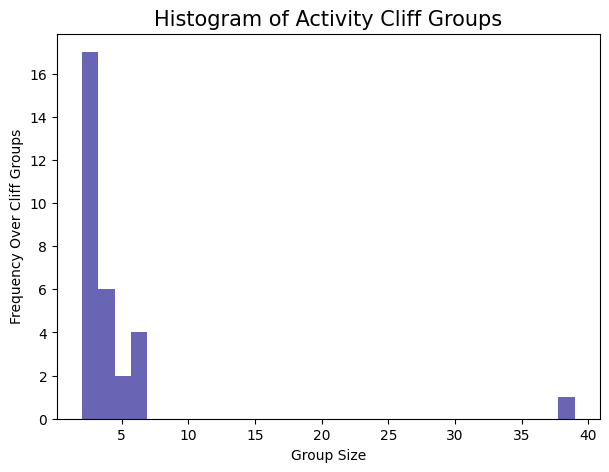

In [12]:
fig = plt.figure(figsize=(7, 5))

plt.hist(data_groups['Size_of_group'], bins=30, color=col_medium_blue)
plt.title("Histogram of Activity Cliff Groups", fontsize=15)
plt.xlabel("Group Size")
plt.ylabel("Frequency Over Cliff Groups")

fig.savefig("figures/histogram_group_sizes.svg", format="svg")
output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "histogram_group_sizes.pdf"), format="pdf")

plt.show()

C:\Users\lisak\AppData\Local\Temp\ipykernel_12108\3477493287.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


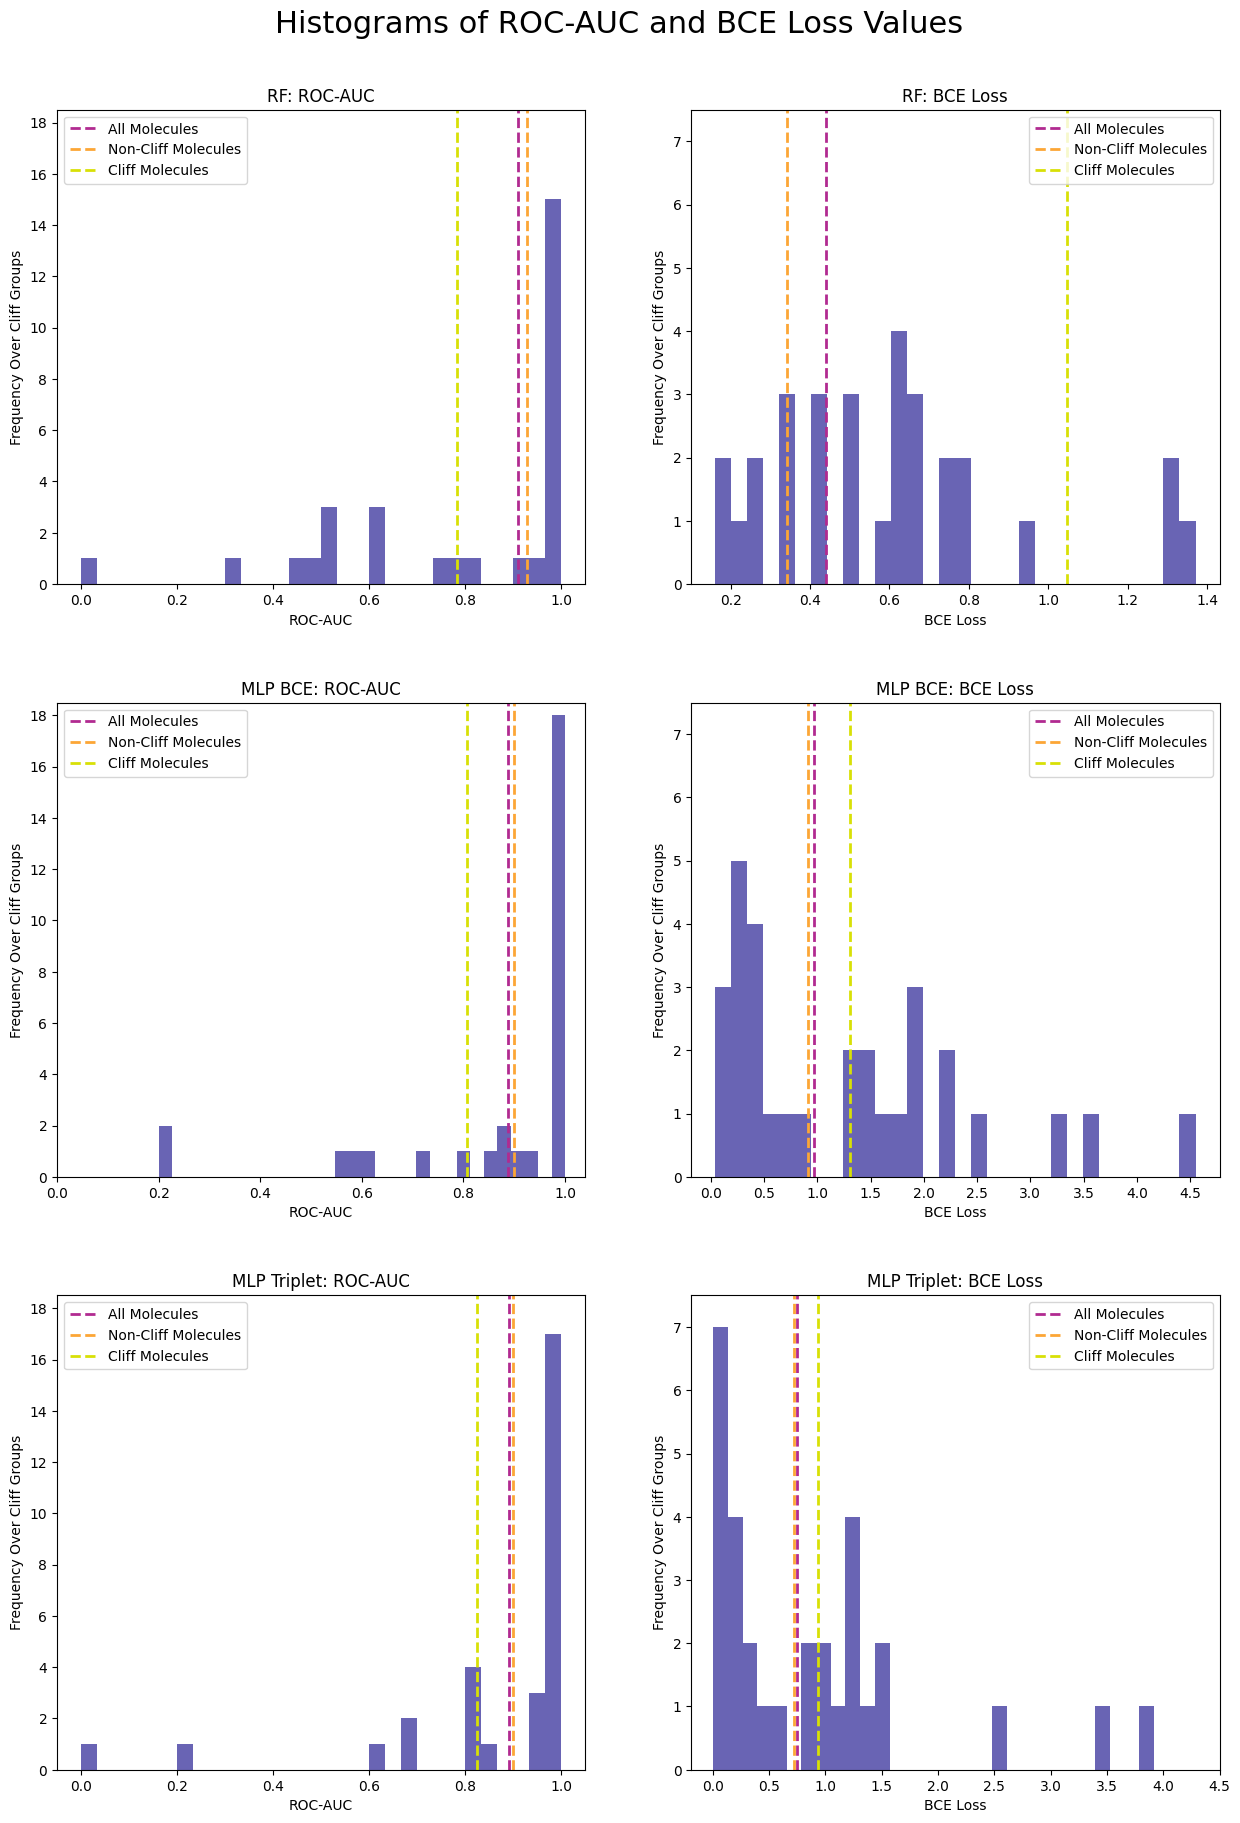

In [13]:
fig = plt.figure(figsize=(15, 20))
gs = gridspec.GridSpec(3, 2, hspace=0.25)

fig.suptitle("Histograms of ROC-AUC and BCE Loss Values", fontsize=22, y=0.93)

for i, results in enumerate(results_networks):
    # ROC-AUC in left column
    ax = fig.add_subplot(gs[i, 0])
    ax.hist(results["ROC-AUC_mean"], bins=30, color=col_medium_blue)
    ax.set_title(f"{network_titles[i]}: ROC-AUC")
    ax.set_xlabel("ROC-AUC")
    ax.set_ylabel("Frequency Over Cliff Groups")
    ax.set_ylim(0, 18.5)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
    ax.axvline(x=results_test[i]['ROC-AUC_mean'][0], color=col_pink, linestyle='dashed', linewidth=2, label="All Molecules")
    ax.axvline(x=results_test[i]['ROC-AUC_mean'][1], color=col_orange, linestyle='dashed', linewidth=2, label="Non-Cliff Molecules")
    ax.axvline(x=results_test[i]['ROC-AUC_mean'][2], color=col_yellow, linestyle='dashed', linewidth=2, label="Cliff Molecules")
    ax.legend(loc="upper left")

    # BCE Loss in right column
    ax = fig.add_subplot(gs[i, 1])
    ax.hist(results["Loss_mean"], bins=30, color=col_medium_blue)
    ax.set_title(f"{network_titles[i]}: BCE Loss")
    ax.set_xlabel("BCE Loss")
    ax.set_ylabel("Frequency Over Cliff Groups")
    ax.set_ylim(0, 7.5)
    if i == 1 or i == 2:
        ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
    ax.axvline(x=results_test[i]['Loss_mean'][0], color=col_pink, linestyle='dashed', linewidth=2, label="All Molecules")
    ax.axvline(x=results_test[i]['Loss_mean'][1], color=col_orange, linestyle='dashed', linewidth=2, label="Non-Cliff Molecules")
    ax.axvline(x=results_test[i]['Loss_mean'][2], color=col_yellow, linestyle='dashed', linewidth=2, label="Cliff Molecules")
    ax.legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(bottom=0.05) 
fig.savefig("figures/histograms.svg", format="svg")
output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "histograms.pdf"), format="pdf")

plt.show()


C:\Users\lisak\AppData\Local\Temp\ipykernel_12108\1111778885.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


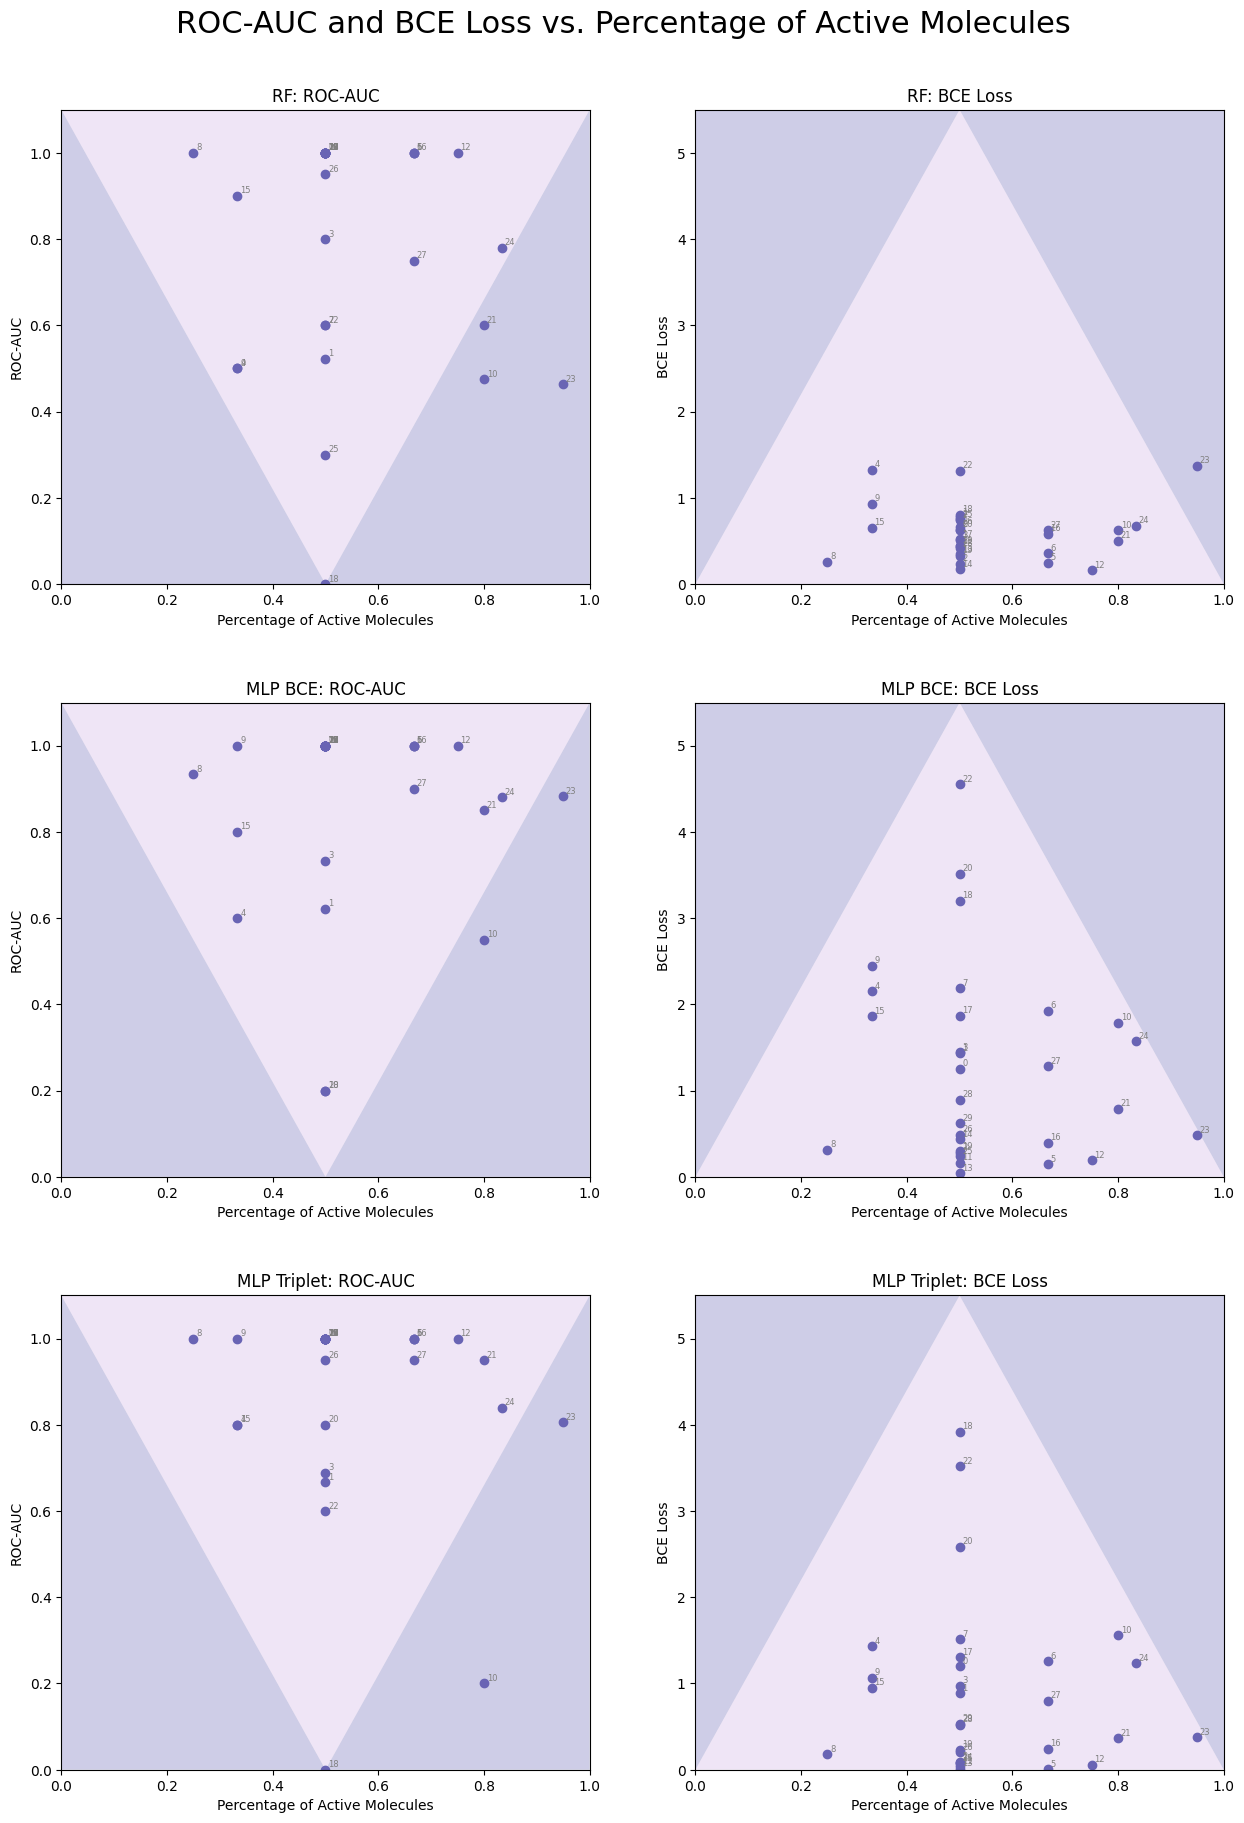

In [14]:
def add_background(ax, color, coords, alpha=0.3):
    polygon = Polygon(coords, closed=True, facecolor=color, edgecolor=None, alpha=alpha, zorder=0)
    ax.add_patch(polygon)

red_triangle_top = [(0, 1.1), (0.5, 0), (1, 1.1)]
yellow_left_top = [(0, 1.1), (0.5, 0), (0, 0)]
yellow_right_top = [(1, 1.1), (0.5, 0), (1, 0)]

red_triangle_bottom = [(0, 0), (0.5, 5.5), (1, 0)]
yellow_left_bottom = [(0, 0), (0.5, 5.5), (0, 5.5)]
yellow_right_bottom = [(1, 0), (0.5, 5.5), (5.5, 5.5)]

fig = plt.figure(figsize=(15, 20))
gs = gridspec.GridSpec(3, 2, hspace=0.25) 

fig.suptitle("ROC-AUC and BCE Loss vs. Percentage of Active Molecules", fontsize=22, y=0.93)


for i, results in enumerate(results_networks):
    # ROC-AUC subplot (left column)
    ax = fig.add_subplot(gs[i, 0])

    add_background(ax, col_violet, red_triangle_top, alpha=0.1)
    add_background(ax, col_dark_blue, yellow_left_top, alpha=0.2)
    add_background(ax, col_dark_blue, yellow_right_top, alpha=0.2)

    ax.scatter(data_groups['Percentage_active'], results["ROC-AUC_mean"], color=col_medium_blue, zorder=1)
    ax.set_title(f"{network_titles[i]}: ROC-AUC")
    ax.set_xlabel("Percentage of Active Molecules")
    ax.set_ylabel("ROC-AUC")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)

    for j in range(len(results)):
        ax.annotate(str(j), (data_groups['Percentage_active'][j], results["ROC-AUC_mean"][j]),
                    textcoords="offset points", xytext=(2, 2), fontsize=6, color="grey")

    # BCE Loss subplot (right column)
    ax = fig.add_subplot(gs[i, 1])

    add_background(ax, col_violet, red_triangle_bottom, alpha=0.1)
    add_background(ax, col_dark_blue, yellow_left_bottom, alpha=0.2)
    add_background(ax, col_dark_blue, yellow_right_bottom, alpha=0.2)

    ax.scatter(data_groups['Percentage_active'], results["Loss_mean"], color=col_medium_blue, zorder=1)
    ax.set_title(f"{network_titles[i]}: BCE Loss")
    ax.set_xlabel("Percentage of Active Molecules")
    ax.set_ylabel("BCE Loss")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 5.5)

    for j in range(len(results)):
        ax.annotate(str(j), (data_groups['Percentage_active'][j], results["Loss_mean"][j]),
                    textcoords="offset points", xytext=(2, 2), fontsize=6, color="grey")

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(bottom=0.05) 
fig.savefig("figures/percentage_active.svg", format="svg")
fig.savefig(os.path.join(output_dir, "percentage_active.pdf"), format="pdf")
plt.show()


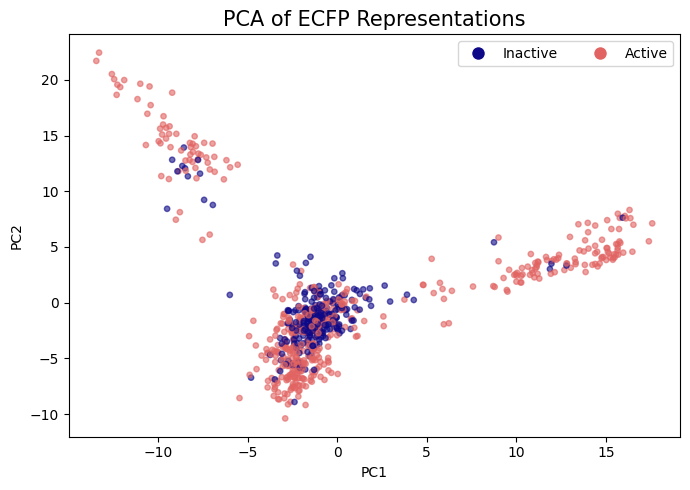

In [15]:
def str_to_array(x):
    return np.array(json.loads(x), dtype=np.float32)

df_test = pd.read_csv("../data/" + dataset + "/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/" + dataset + "/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test['cliff_group'] = df_test['cliff_group'].fillna(-1)
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

class_colors = {0: col_dark_blue, 1: col_salmon}

ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)

fig, ax = plt.subplots(figsize=(7, 5))

colors = df_test["active"].map(class_colors)
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], 
                     c=colors, s=15, alpha=0.6)

ax.set_title("PCA of ECFP Representations", fontsize=15)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], 
               markersize=10, label='Inactive'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], 
               markersize=10, label='Active')
]
ax.legend(handles=handles, loc='upper right', ncol=2)

fig.tight_layout()

os.makedirs("figures", exist_ok=True)
svg_path = "figures/pca_active_inactive.svg"
fig.savefig(svg_path, format="svg", bbox_inches='tight')

output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "pca_active_inactive.pdf"), format="pdf")

plt.show()

In [16]:
def plot_pca_ecfp(df_test, name):

    fig, ax = plt.subplots(figsize=(10, 6))

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    ecfp_array = df_test["ecfp"].apply(str_to_array)
    ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(ecfp_array)

    unique_classes = df_test["cliff_group"].unique()

    cmap = plt.get_cmap("gist_ncar", len(unique_classes))
    color_map = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
    color_map = {cls: cmap(i / len(unique_classes)) for i, cls in enumerate(unique_classes)}

    colors = df_test["cliff_group"].map(color_map)

    ax.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, alpha=0.4, s=15)
    ax.set_title("PCA of ECFP Representations", fontsize=15)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    for i, (x, y) in enumerate(principal_components):
        ax.annotate(
            str(df_test["cliff_group"].iloc[i]),  # label
            (x, y),  # position
            textcoords="offset points",
            xytext=(1.5, 1.5),  # offset
            fontsize=5,
            color="grey"
        )

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label="-1 (No Cliff)" if cls == -1 else str(cls))
        for cls in unique_classes
    ]
    ax.legend(handles=handles, loc="center left", ncol=2, bbox_to_anchor=(1.02, 0.5), title="Cliff Group")

    plt.tight_layout()


    os.makedirs("figures", exist_ok=True)
    svg_path = "figures/" + name + ".svg"
    plt.savefig(svg_path, format="svg", bbox_inches='tight')
    output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, name + ".pdf"), format="pdf")

    plt.show()

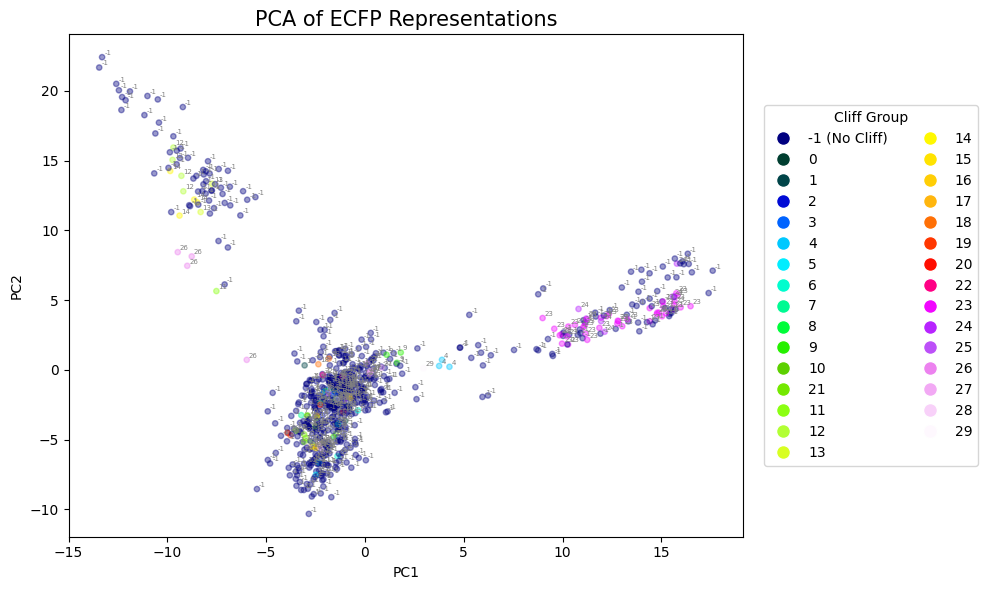

In [17]:
plot_pca_ecfp(df_test, name="pca_all_groups")

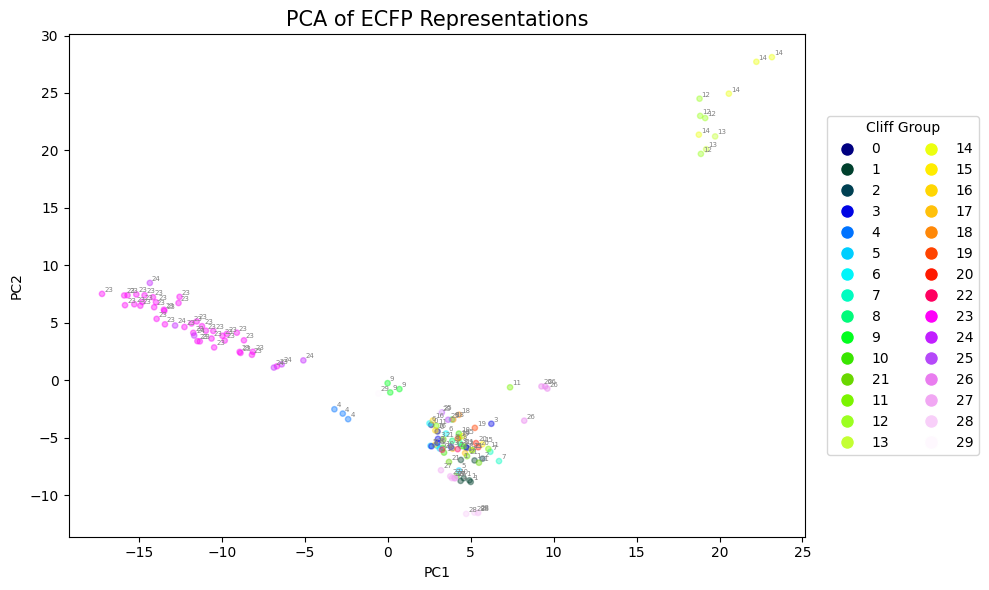

In [18]:
df_filtered = df_test[df_test["cliff_group"] != -1]

plot_pca_ecfp(df_filtered, "pca_cliff_groups")

In [19]:
def plot_pca_ecfp_with_loss_per_datapoint(df, losses, cliff_text, annotate_cliffs=False, name=""):

    assert len(df) == len(losses[0])

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(
        15, 5), gridspec_kw={"width_ratios": [1, 1, 1]})

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    ecfp_array = df["ecfp"].apply(str_to_array)
    ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(ecfp_array)

    losses = [losses[0]['Loss_mean'].values.flatten(
    ), losses[1]['Loss_mean'].values.flatten(), losses[2]['Loss_mean'].values.flatten()]

    overall_min = min(losses[0].min(), losses[1].min(), losses[2].min())
    overall_max = max(losses[0].max(), losses[1].max(), losses[2].max())

    alpha = 0.3

    base_cmap = plt.colormaps["plasma"]
    colors_with_alpha = base_cmap(np.linspace(0, 1, 256))
    colors_with_alpha[:, 3] = alpha  
    transparent_cmap = mcolors.ListedColormap(colors_with_alpha)
    norm = plt.Normalize(vmin=overall_min, vmax=overall_max)

    if annotate_cliffs:
        markers = {0: "x", 1: "o"}

        for i, (curr_losses, network_title) in enumerate(zip(losses, network_titles)):
            for cliff_value in [0, 1]:
                mask = df["cliff_mol_binary"] == cliff_value
                axes[i].scatter(
                    principal_components[mask, 0],
                    principal_components[mask, 1],
                    c=curr_losses[mask],
                    cmap=transparent_cmap,
                    alpha=alpha,
                    s=10,
                    marker=markers[cliff_value],
                    label="Cliff Molecule" if cliff_value == 1 else "Non-Cliff Molecule"
                )

            axes[i].set_title(network_title)
            axes[i].set_xlabel("PC1")
            axes[i].set_ylabel("PC2")

        fig.suptitle(f"PCA of ECFP Representations", fontsize=20)

    else:
        for i, (curr_losses, network_title) in enumerate(zip(losses, network_titles)):
            axes[i].scatter(principal_components[:, 0], principal_components[:, 1],
                            c=curr_losses, cmap=transparent_cmap, alpha=alpha, s=15)
            axes[i].set_title(network_title)
            axes[i].set_xlabel("PC1")
            axes[i].set_ylabel("PC2")

        fig.suptitle(f"PCA of ECFP Representations ({cliff_text})", fontsize=20)

    cbar = fig.colorbar(cm.ScalarMappable(cmap=transparent_cmap, norm=norm),
                        ax=axes[:], orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("BCE Loss of Datapoint")

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  

    if annotate_cliffs:
        handles = [
            plt.Line2D([0], [0], marker='o', color='black',
                       linestyle='None', markersize=6, label='Cliff Molecule'),
            plt.Line2D([0], [0], marker='x', color='black',
                       linestyle='None', markersize=6, label='Non-Cliff Molecule')
        ]

        fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.45, -0.05), ncol=2)


    os.makedirs("figures", exist_ok=True)
    svg_path = "figures/" + name + ".svg"
    plt.savefig(svg_path, format="svg", bbox_inches='tight')
    

    output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, name + ".pdf")

    plt.savefig(pdf_path, format="pdf", bbox_inches='tight')

    plt.show()

C:\Users\lisak\AppData\Local\Temp\ipykernel_12108\3948468637.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


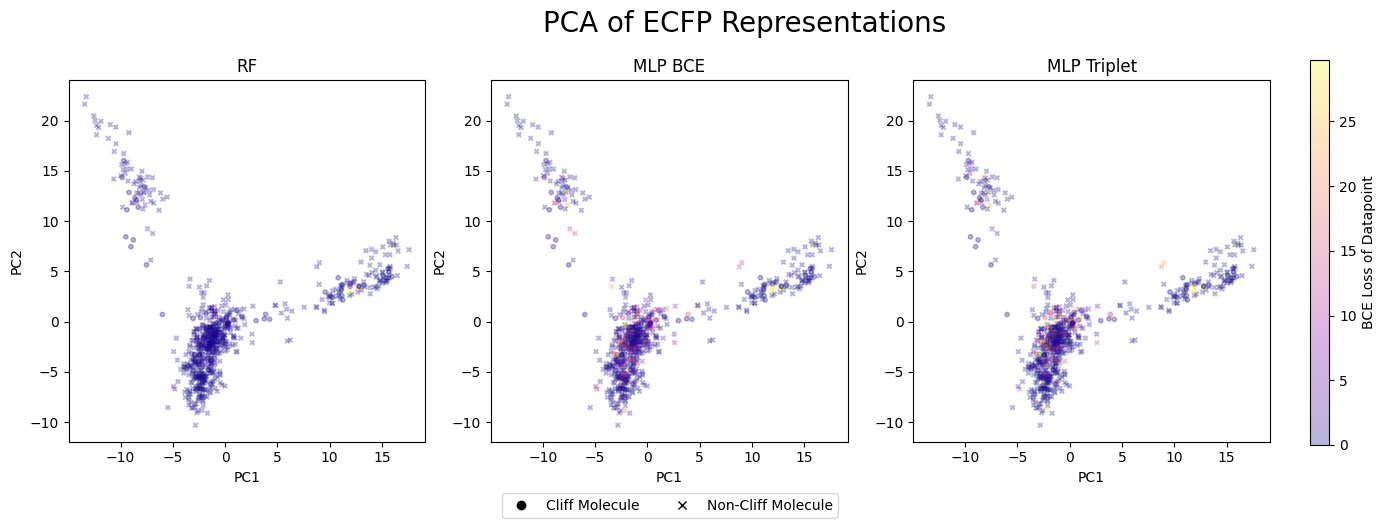

In [20]:
plot_pca_ecfp_with_loss_per_datapoint(df_test, losses_per_datapoint_test_total, "All Molecules", annotate_cliffs=True, name="pca_loss_per_datapoint")

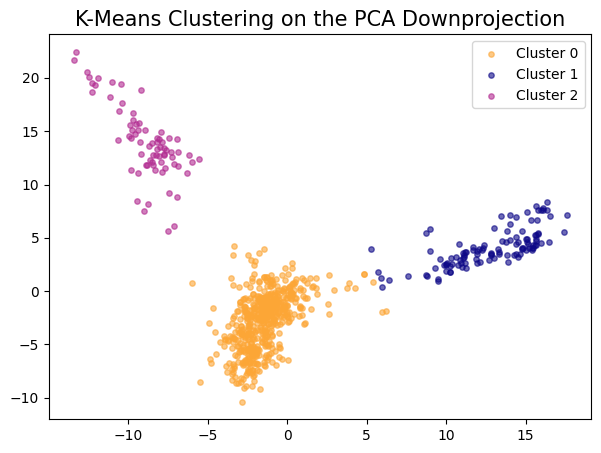

In [21]:
ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)

custom_colors = [col_orange, col_dark_blue, col_pink]

if dataset == "CHEMBL214_Ki":        
    kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=12, init=np.array([[-10, 25], 
                                                             [25, -5]]))
elif dataset == "CHEMBL234_Ki":
    kmeans = sklearn.cluster.KMeans(n_clusters=3, random_state=12)
else:
    raise Exception(f"No K-Means configuration defined for dataset '{dataset}'.")

labels = kmeans.fit_predict(principal_components)
np.save(f"../results/{dataset}/Clustering_Labels.npy", np.array(labels))

unique_labels = set(labels)
colors = [custom_colors[i] for i in range(len(unique_labels))]

plt.figure(figsize=(7, 5))
for label, color in zip(unique_labels, colors):
    if label == -1:
        # noise points would be marked in black
        color = (0, 0, 0, 1) 

    plt.scatter(principal_components[labels == label, 0], principal_components[labels == label, 1], c=[color], label=f"Cluster {label}", s=15, alpha=0.6)

plt.legend()
plt.title("K-Means Clustering on the PCA Downprojection", fontsize=15)

name = "pca_clusters"
os.makedirs("figures", exist_ok=True)
svg_path = "figures/" + name + ".svg"
plt.savefig(svg_path, format="svg", bbox_inches='tight')

output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, name + ".pdf"), format="pdf", bbox_inches='tight')

plt.show()


In [22]:
prop_ac_total = len(df_test[df_test["cliff_mol_binary"] == 1]) / len(df_test)

df_filtered = df_test.iloc[np.where(labels == 0)]
prop_ac_cluster0 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

df_filtered = df_test.iloc[np.where(labels == 1)]
prop_ac_cluster1 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

if dataset == 'CHEMBL234_Ki':
    df_filtered = df_test.iloc[np.where(labels == 2)]
    prop_ac_cluster2 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

size_total = len(df_test)

df_filtered = df_test.iloc[np.where(labels == 0)]
size_cluster_0 = len(df_filtered)

df_filtered = df_test.iloc[np.where(labels == 1)]
size_cluster_1 = len(df_filtered)

if dataset == 'CHEMBL234_Ki':
    df_filtered = df_test.iloc[np.where(labels == 2)]
    size_cluster_2 = len(df_filtered)

tables_clusters = []
overall_results_test_set = []

def round_list(values, decimals=4):
    return [round(v, decimals) for v in values]

for i in range(3):
    curr_tables = results_clusters[i]  # RF, MLP BCE, MLP Cosine
    results_total, results_non_cliffs, results_cliffs = curr_tables

    curr_overall_results = results_test[i]

    if dataset == 'CHEMBL234_Ki':
        table_cluster = {
            "Cluster": ["Dataset", "Cluster0", "Cluster1", "Cluster 2"],
            "Number of Molecules": round_list([size_total, size_cluster_0, size_cluster_1, size_cluster_2], 6),

            "Proportion of ACs": round_list([prop_ac_total, prop_ac_cluster0, prop_ac_cluster1, prop_ac_cluster2], 6),

            "ROC-AUC (all molecules)": round_list([curr_overall_results['ROC-AUC_mean'][0], results_total['ROC-AUC_mean'][0], 
                                        results_total['ROC-AUC_mean'][1], results_total['ROC-AUC_mean'][2]]),
            "ROC-AUC (non-cliff molecules)": round_list([curr_overall_results['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][0], 
                                        results_non_cliffs['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][2]]),
            "ROC-AUC (cliff molecules)": round_list([curr_overall_results['ROC-AUC_mean'][2], results_cliffs['ROC-AUC_mean'][0], 
                                        results_cliffs['ROC-AUC_mean'][1], results_cliffs['ROC-AUC_mean'][2]]),     
                                        
                                        
            "BCE Loss (all molecules)": round_list([curr_overall_results['Loss_mean'][0], results_total['Loss_mean'][0], 
                                        results_total['Loss_mean'][1], results_total['Loss_mean'][2]]),
            "BCE Loss (non-cliff molecules)": round_list([curr_overall_results['Loss_mean'][1], results_non_cliffs['Loss_mean'][0], 
                                        results_non_cliffs['Loss_mean'][1], results_non_cliffs['Loss_mean'][2]]),
            "BCE Loss (cliff molecules)": round_list([curr_overall_results['Loss_mean'][2], results_cliffs['Loss_mean'][0], 
                                        results_cliffs['Loss_mean'][1], results_cliffs['Loss_mean'][2]]),  
        }

    elif dataset == 'CHEMBL214_Ki':
        table_cluster = {
            "Cluster": ["Dataset", "Cluster0", "Cluster1"],
            "Proportion of ACs": [prop_ac_total, prop_ac_cluster0, prop_ac_cluster1],

            "BCE Loss (all molecules)": [curr_overall_results['Loss_mean'][0], results_total['Loss_mean'][0], 
                                        results_total['Loss_mean'][1]],
            "BCE Loss (non-cliff molecules)": [curr_overall_results['Loss_mean'][1], results_non_cliffs['Loss_mean'][0], 
                                        results_non_cliffs['Loss_mean'][1]],
            "BCE Loss (cliff molecules)": [curr_overall_results['Loss_mean'][2], results_cliffs['Loss_mean'][0], 
                                        results_cliffs['Loss_mean'][1]],  

            "ROC-AUC (all molecules)": [curr_overall_results['ROC-AUC_mean'][0], results_total['ROC-AUC_mean'][0], 
                                        results_total['ROC-AUC_mean'][1]],
            "ROC-AUC (non-cliff molecules)": [curr_overall_results['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][0], 
                                        results_non_cliffs['ROC-AUC_mean'][1]],
            "ROC-AUC (cliff molecules)": [curr_overall_results['ROC-AUC_mean'][2], results_cliffs['ROC-AUC_mean'][0], 
                                        results_cliffs['ROC-AUC_mean'][1]],                        

        }

    table_cluster = pd.DataFrame(table_cluster)

    tables_clusters.append(table_cluster)



In [23]:
print("RF:")
tables_clusters[0]

RF:


,Cluster,Number of Molecules,Proportion of ACs,ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules),BCE Loss (all molecules),BCE Loss (non-cliff molecules),BCE Loss (cliff molecules)
0,Dataset,733,0.137790,0.9090,0.9292,0.7826,0.4396,0.3425,1.0476
1,Cluster0,547,0.127971,0.8978,0.9176,0.7207,0.4065,0.3725,0.6386
2,Cluster1,113,0.168142,0.5674,0.7283,0.5708,0.6936,0.2239,3.0174
3,Cluster 2,73,0.164384,0.8578,0.7645,0.9886,0.2947,0.2908,0.3146


In [24]:
print("MLP BCE:")
tables_clusters[1]

MLP BCE:


,Cluster,Number of Molecules,Proportion of ACs,ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules),BCE Loss (all molecules),BCE Loss (non-cliff molecules),BCE Loss (cliff molecules)
0,Dataset,733,0.137790,0.8885,0.8993,0.8059,0.9695,0.9153,1.3083
1,Cluster0,547,0.127971,0.8694,0.8818,0.7458,1.1049,1.0578,1.4259
2,Cluster1,113,0.168142,0.7604,0.6527,0.8271,0.4562,0.2487,1.4828
3,Cluster 2,73,0.164384,0.8499,0.7661,0.9943,0.7492,0.8285,0.3460


In [25]:
print("MLP Triplet:")
tables_clusters[2]

MLP Triplet:


,Cluster,Number of Molecules,Proportion of ACs,ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules),BCE Loss (all molecules),BCE Loss (non-cliff molecules),BCE Loss (cliff molecules)
0,Dataset,733,0.137790,0.8905,0.9002,0.8237,0.7491,0.7195,0.9343
1,Cluster0,547,0.127971,0.8768,0.8882,0.7861,0.8520,0.8278,1.0173
2,Cluster1,113,0.168142,0.6543,0.4516,0.7625,0.3817,0.2244,1.1600
3,Cluster 2,73,0.164384,0.8604,0.7848,1.0000,0.5465,0.6357,0.0932
